This script mainly concerns the computation of:
- Contingency table:
    - Presented in the form of a confusion matrix, it displays the total amounts of land use transitions between two maps. Specifically, it sums up which cells from base year remained the same and which transitioned. Thus it provides information on land use inertia, and, in the case of a state change, which are the most likely transitions.

- Enrichment factors:
    - Evaluates the neighborhood of all cells that changed state in search for a surrounding land use composition that might explain such change. For example, if there's a change from residential to retail/services, it looks in the neighborhood for land uses that are over or under represented when compared to the average cell.
    
Those quantities are input of the initiation values of the neighborhood effects.

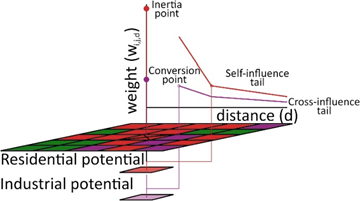

***The above quantities need only be computed for the base year, on the one hand, and the calibration year, on the other, that is, 2011 and 2017.***

In [1]:
import fiona
import h3
import os
import pathlib
import re
import warnings
    
import contextily as cx
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.cg import KDTree
from libpysal.weights import DistanceBand


%matplotlib inline
%config InlineBackend.figure_format='retina'

# Preliminaries

## Parent Folders

In [2]:
db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)

In [3]:
def _get_path_to_gpkg():
    re_path = r'(BH_)(hex_\d{1,2})(_with_land_uses\.gpkg)'

    for file in (out_folder / 'A').iterdir():
        match = re.search(re_path, file.name)
        # If there's no search result, match is None
        if match:
            path_to_hexes = file
            
            # The gdf in each layer was indexed by a H3 label,
            # and the index name corresponded to the hex resolution.
            # When saving to geopackage, the index name is lost.
            # This parameter takes the info on resolution from the
            # file to later insert it back to the data
            hex_resolution = match.group(2) # .group() is one-indexed
            
            
    return path_to_hexes, hex_resolution


def _get_hexagons_with_uses(path, layername, hex_resolution):
    # The following is just because Fiona is emmiting an annoying
    # warning message that is most likely useless (see link for
    # this issue below)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                category=RuntimeWarning,)
        hex_ = gpd.read_file(path, layer=layername)
        
    hex_['year'] = layername
    
    
    return hex_.rename(columns={'index': hex_resolution})


def get_land_use_maps():
    """Reads geopackage containing land use maps for 
    each study year. It assumes one year per layer and
    that each year has the same structure.
    """
    path, hex_res =  _get_path_to_gpkg()
    
    hex_series = []
    for layername in fiona.listlayers(path):
        hex_series.append(_get_hexagons_with_uses(path, layername, hex_res))
        
    
    return pd.concat(hex_series, ignore_index=True)

https://github.com/Toblerity/Fiona/issues/986

In [4]:
hexes = get_land_use_maps()

hexes.head(3)

,hex_12,pop,income,base_pop,x_epsg31983,y_epsg31983,category,use,area_m2,geometry,year,activities
0,8ca881a494429ff,2.720809,1110.51,2.720809,600238.070442,7.789818e+06,active,residential,401.607621,"POLYGON ((600239.371 7789808.437, 600248.275 7...",2011,NaN
1,8ca88cdb59159ff,0.281796,3944.01,0.281796,608371.114363,7.792865e+06,static,infrastructure,NaN,"POLYGON ((608372.975 7792854.191, 608381.884 7...",2011,NaN
2,8ca88cd9c5713ff,3.497341,2578.64,3.497341,609600.949491,7.803942e+06,passive,vacant,2741.663778,"POLYGON ((609602.810 7803931.365, 609611.724 7...",2011,NaN


In [5]:
def enforce_preferred_order(data):
    """Turns land use types and categories into
    categorical, as this will aid visualizations.
    """
    categoricals = {
        'category': ['active', 'passive', 'static'],
        
        'use': ['residential', 'subnormal', 'retail/services',
                'mixed', 'vacant', 'amenities', 'public services',
                'industry', 'infrastructure']
                   }
    
    for each in ['category', 'use']:
        data[each] = pd.Categorical(data[each],
                                      categories=categoricals[each],
                                      ordered=True,)
        
        
    return data.sort_values(['category', 'use'])
        
        
hexes = enforce_preferred_order(hexes)
      

# Land Coverage by Use

In [6]:
def _get_palette(which):
    type_palette = {'active': '#C97064',
                    'static': '#39487F',
                    'passive': '#527048',}
    
    category_palette = {'residential': '#FECEF1',
                        'subnormal': '#B05F66',
                        'retail/services': '#3B727C',
                        'mixed': '#60E1E0',
                        'vacant': '#82A775',
                        'industry': '#291A10',
                        'infrastructure': '#FFFBDB',
                        'public services': '#A85118',
                        'amenities': '#7D573C',}

    if which == 'category':
        return type_palette
    else:
        return category_palette

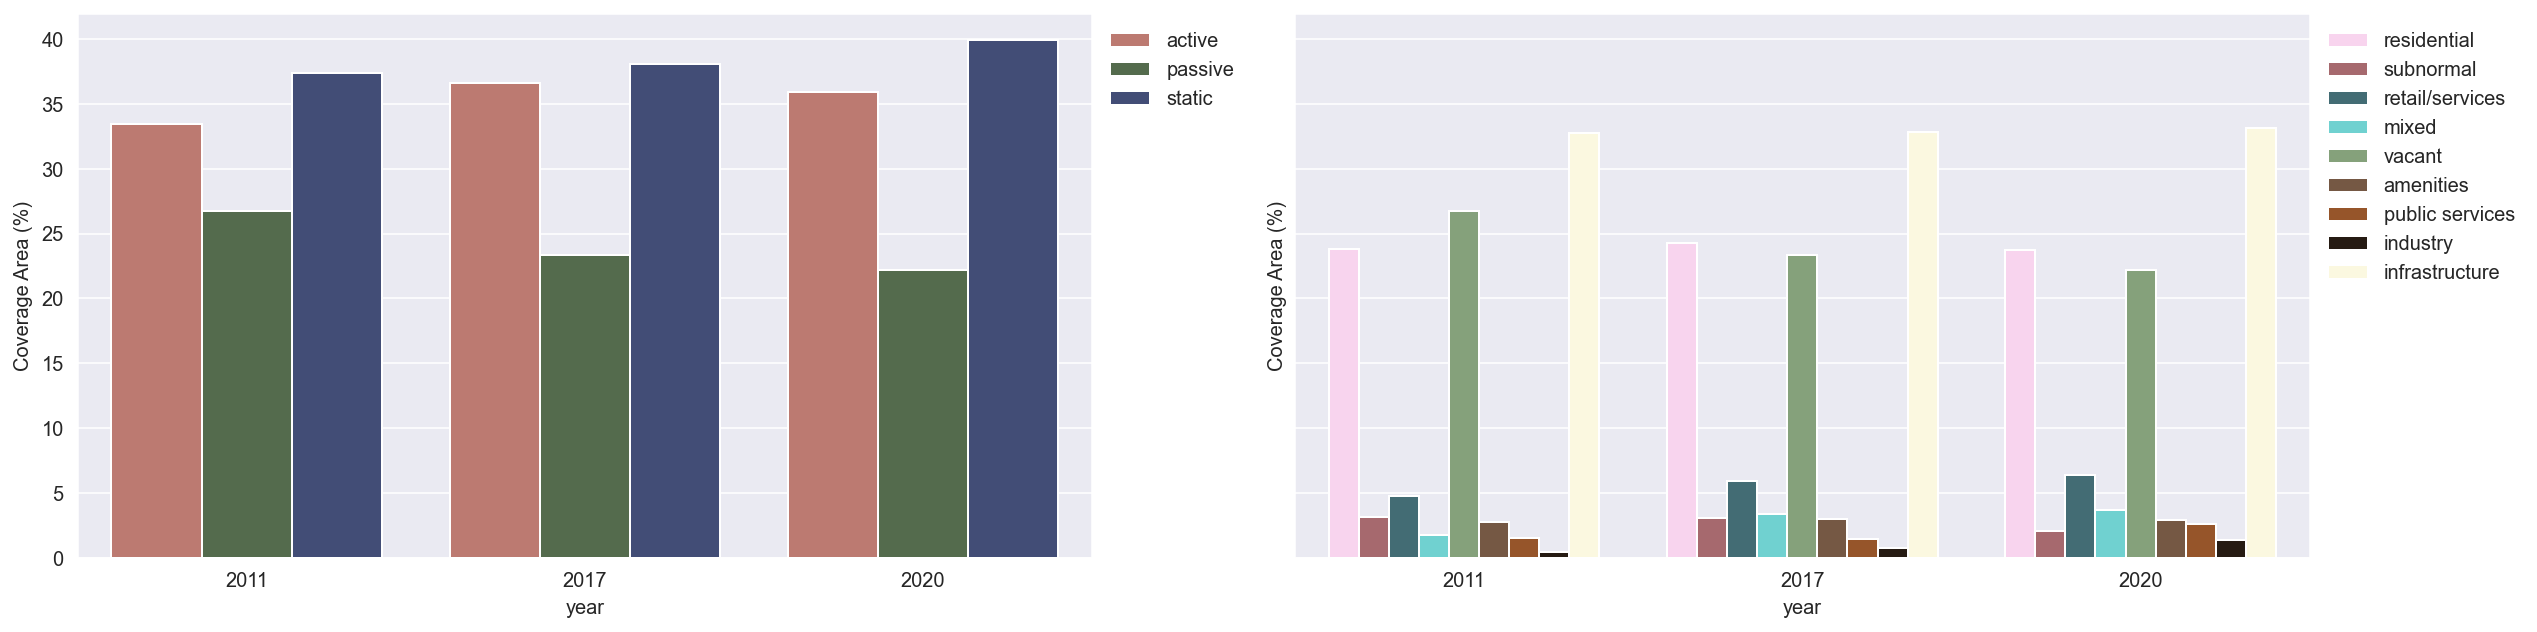

In [7]:
def _agg_cells_by_use(gdf, group_on, total_cells):
    def _pct_by_use(col):
        return len(col) / total_cells * 100
    
    summary = pd.pivot_table(gdf,
                             index=['year', group_on],
                             aggfunc=_pct_by_use)
    
    
    return summary.reset_index()
    


def summarize_land_use_extentions(gdf):
    """The number of cells in the study area is constant
    in each map, the only thing that changes is their composition.
    Thus, this function plots the relative number of cells that
    each land use occupies.
    """
    # I took the 0th index, but any would do, as cell count is constant
    total_cells = gdf.year.value_counts()[0]
    
    sns.set_style('darkgrid')
    f, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)
    
    for i, each in enumerate(['category', 'use']):
        summary = _agg_cells_by_use(gdf, each, total_cells)
        
        ax = axes[i]
        sns.barplot(data=summary,
                    x='year',
                    y=gdf.columns[0],
                    hue=each,
                    palette=_get_palette(each),
                    ax=ax)
        ax.legend(bbox_to_anchor=(1,1),
                  loc='upper left',
                  frameon=False)
        ax.set_ylabel('Coverage Area (%)')

        
summarize_land_use_extentions(hexes)

# Contingency Table

It should be noted that even though some convertions do happens, they are not allowed in the model dynamics. That is, ***public*** and ***industry*** categories are supposed to be fixed and changes in those between 2011 and 2017 are attributed to either top down decisions - not strictily tied to (local) city dynamics - or to errors in parcel classification during the construction of the land use maps. The latter are most propbably caused by two reasons. First and foremost, the source maps themselves, as provided by BH city hall are not perfect, as that would require that all raw databases used in the making of those maps were both perfectly complete and perfectly compatible. That, of course, is not the case. On top of that, my own imputation scheme could lead to some imprecisions. For example, when a hexagon intersected with more than one land use, it would receive the state of the one which occupied most of its area, not to mention the assumptions I made for parcels with no information.

That does not mean that some of the transitions observed for other uses cannot be attributed to the reasons above, but it should be safe to assume that most of them are more strongly connected with local dynamics. In light of all that, I will ignore industrial and public land when computing the quantities below.

In [8]:
def _restructure_data(lu_maps, t0, t1): 
    t0 = f'{t0}'
    t1 = f'{t1}'
    hex_labels = (lu_maps
                  .filter(regex='hex')
                  .columns[0])
    df = lu_maps.set_index(hex_labels)
    
    base_map = df.loc[df.year==t0, 'use']
    future_map = df.loc[df.year==t1, 'use']
    
    
    return pd.concat([base_map, future_map],
                     keys=[t0, t1],
                     axis=1,)


def get_contingency_table(lu_maps, t0, t1):
    """Gets a contingency table for the land
    use tansitions between years t0 and t1.
    
    Parameters
    ----------
    lu_maps : GeoDataFrame
        "Time series" of land use maps
        for the study area
    t0 : int
    t1 : int
    
    Returns
    -------
    contingency : DataFrame
    """
    df = _restructure_data(lu_maps, t0, t1)
    
    df = df.groupby([f'{t0}', f'{t1}']).apply(len)
    
    
    return df.unstack()

In [9]:
def _heatmap_subplot(df, ax, title):
    df.fillna(0, inplace=True)
    for i in range(len(df)):
        df.iloc[i, i] = np.nan
        
    df /= 1_000
    
    sns.heatmap(df, ax=ax, cmap='RdPu', annot=True)
    
    ax.set_title(title, fontsize='xx-large', fontweight='bold')
    
    ax.xaxis.set(label_position='top',
                 ticks_position='top')
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=90, 
                       fontsize='x-large')
    
    ax.set_yticklabels(ax.get_yticklabels(),
                       rotation=0, 
                       fontsize='x-large')
    

def plot_contingency_heatmaps(hexes):
    contingencies = {
        'Calibration Span': get_contingency_table(hexes, 2011, 2017),
        'Validation Span': get_contingency_table(hexes, 2017, 2020),
    }
    
    f, axes = plt.subplots(ncols=2, figsize=(20, 10), sharex=True)
    
    for i, each in enumerate(['Calibration Span', 'Validation Span']):
        ax = axes[i]
        _heatmap_subplot(contingencies[each],
                         ax,
                         each)
        plt.tight_layout()
        
        

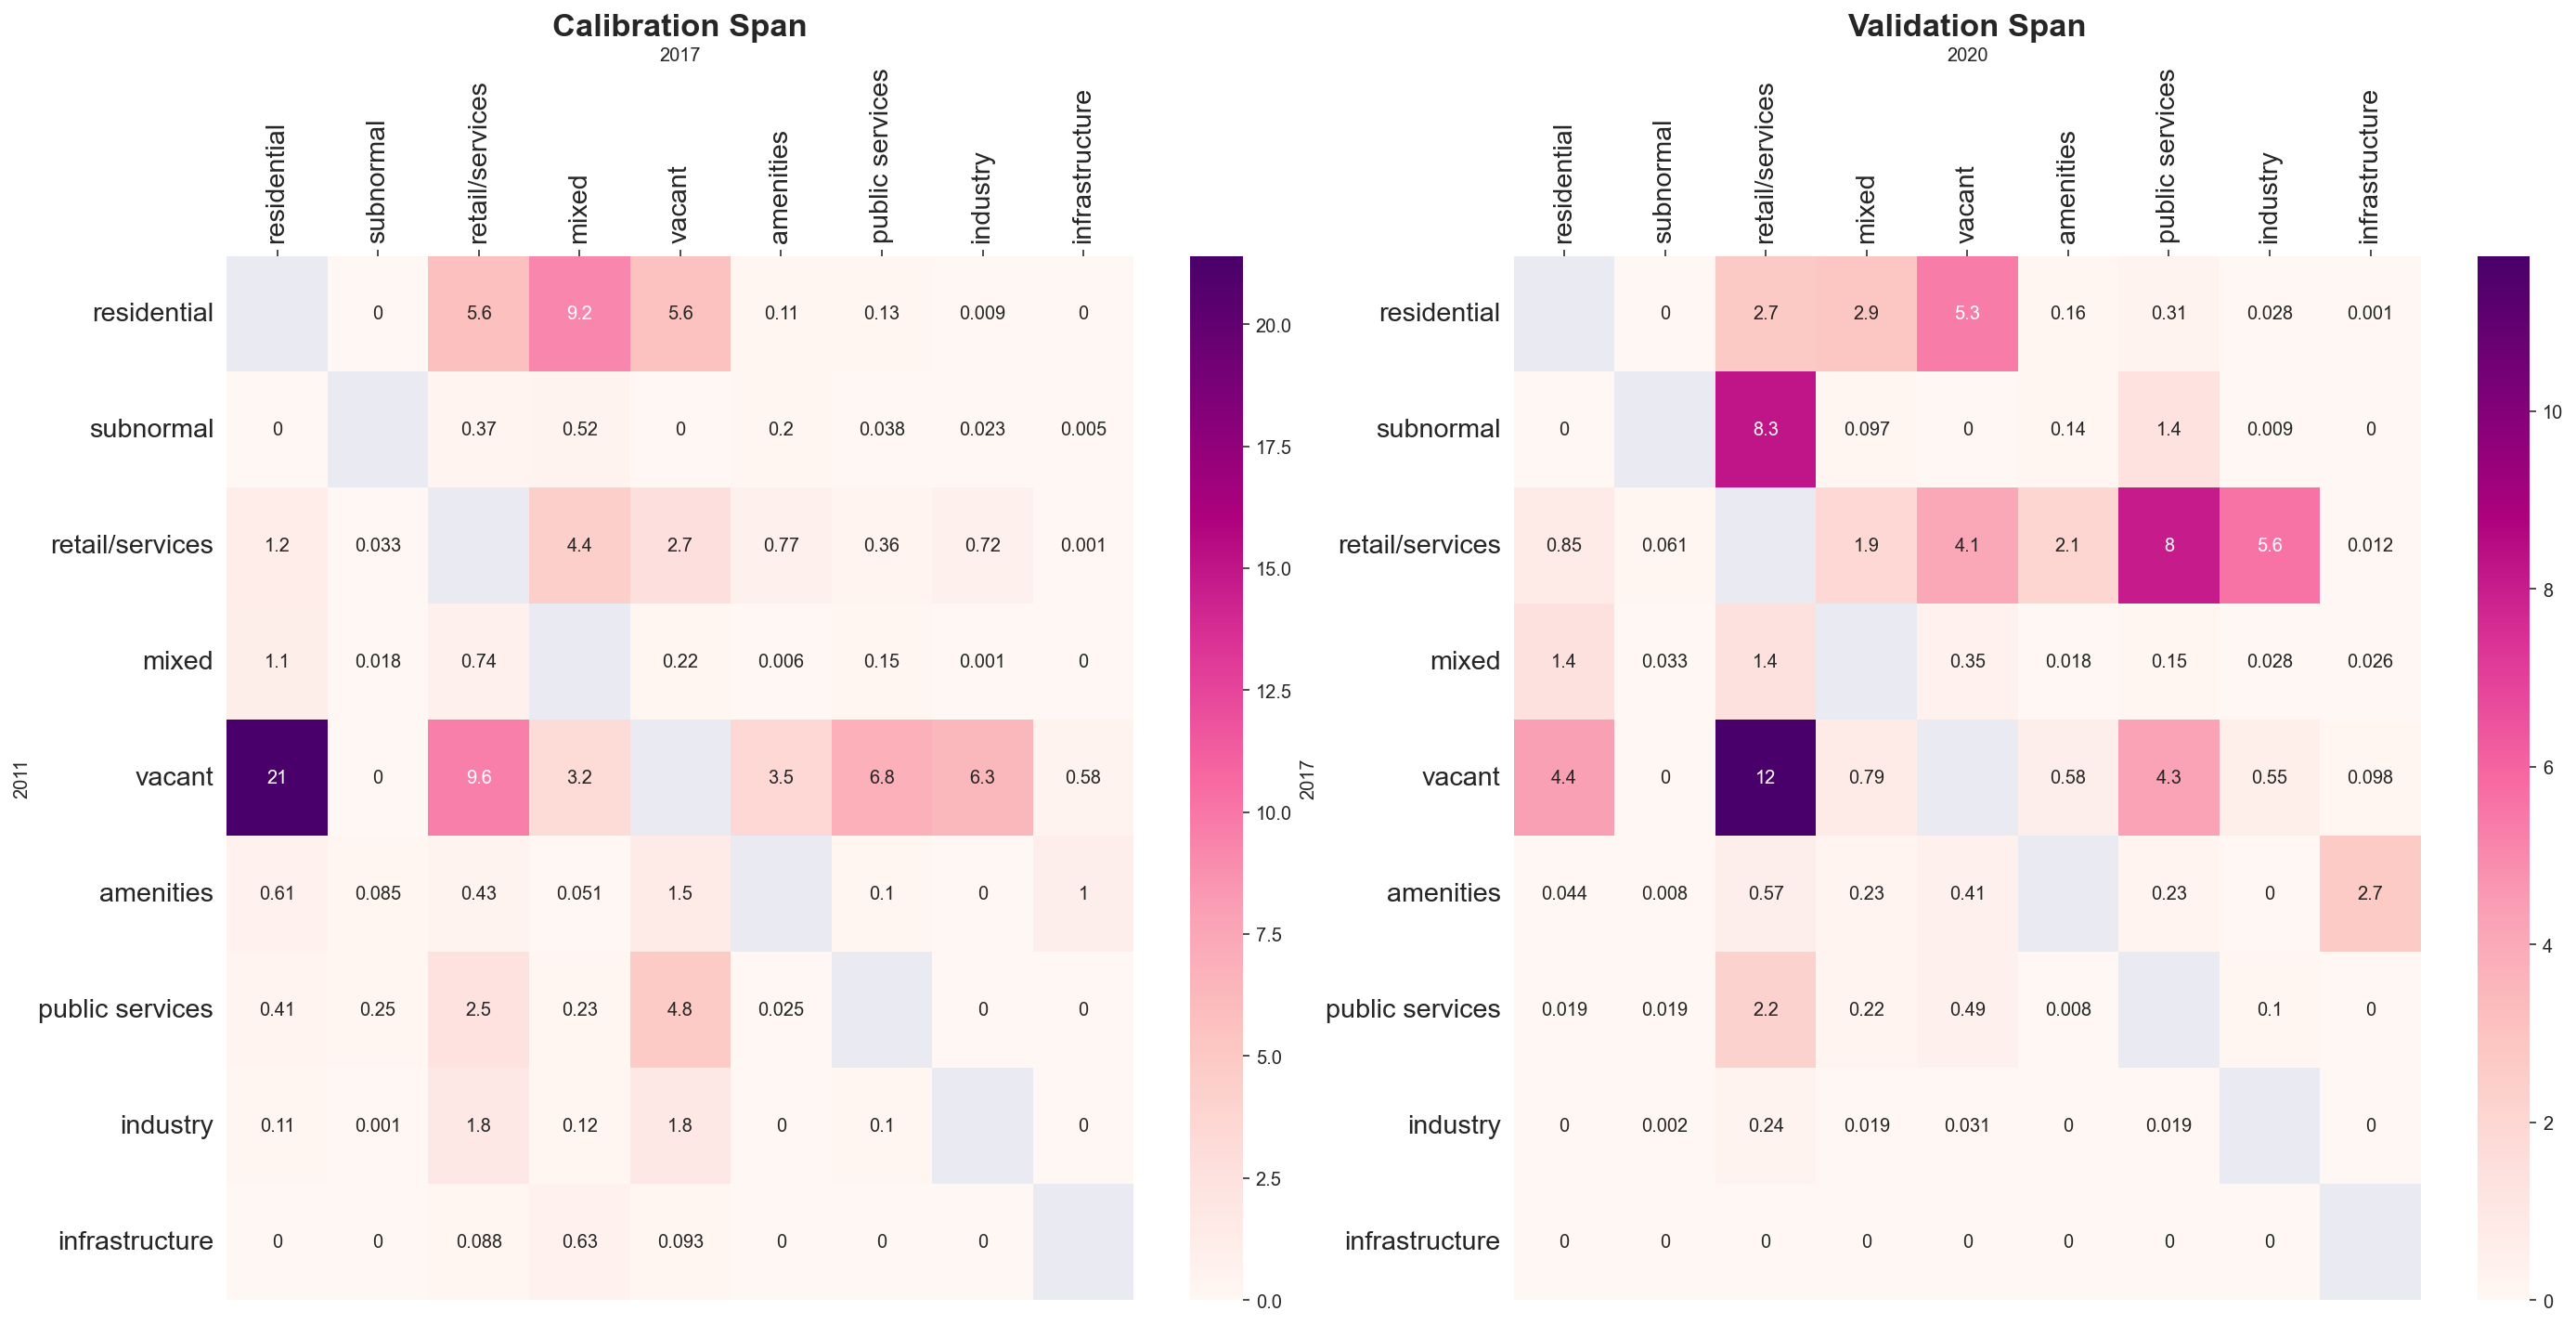

In [10]:
plot_contingency_heatmaps(hexes)

## Inertia and Convertion Rates

In [ ]:
def _compute_inertia(df):
    """
    Parameters
    ----------
    df : DataFrame
        The contingency table
        
    Returns
    -------
    ir : DataFrame
        Inertia rates for modeled land uses
    """
    ir = {}
    for each in df.columns:
        numerator = df.loc[each, each]        
        denominator = df.loc[each, :].sum()
        
        ir[each] = numerator / denominator
        
    ir = pd.DataFrame.from_dict(ir,
                                orient='index',
                                columns=['inertia_rate'],)
        
    return ir


def _parse_convertions(cr):
    """Takes the dictionary with convertion rates and
    creates a DataFrame that can be read in the same way
    as the contingency table.
    """
    cr = pd.DataFrame.from_dict(cr)
    
    # Note that the conversion rate from use k to use l,
    # in the dictionary could be accessed by cr[k][l], but, 
    # when the DataFrame was created, that would become
    # cr.loc[l, k]. I prefer the former index ordering,
    # which seems more natural and it is compatible with
    # the reading of the contingency table.
    cr = cr.T
    
    cr =  _custumize_idx(cr)
    
    
    return cr


def _compute_conversion(df):
    """
    Parameters
    ----------
    df : DataFrame
        The contingency table
        
    Returns
    -------
    cr : DataFrame
        Convertion rates for modeled land uses
    """
    cr = {}
    for each in df.columns:
        numerator = df.loc[each, df.columns != each]
        denominator = numerator.sum()
        rates = numerator / denominator
        
        # Note that this creates a as nested dictionary.
        # Each key contains a dictionary of convertion rates,
        # so that the convertion rates from use k to use l can
        # be accessed as # cr[k][l].        
        cr[each] = rates.to_dict()
        
           
    cr = _parse_convertions(cr)
        
        
    return cr

    
def get_local_effects(lu_maps, t0, t1):
    """Refers to the inherent characteristicts of
    the modeled land uses. That is, their inertia and 
    the states they are most likely to convert to.
    """
    df = lu_maps.loc[lu_maps['type'] != 'static']
    contingency = get_contingency_table(df, t0, t1)
    
    inertias = _compute_inertia(contingency)
    conversions = _compute_conversion(contingency)
    
    
    return inertias, conversions


In [ ]:
inertias, convertions = get_local_effects(hexes, 2011, 2017)

## Enrichment Factors

Before defining the enrichment factor, the neighborhood must be defined in more precise terms. Usually the literature defines the neighborhood in terms of the number of cells in each direction, therefore, the extension of a neighborhood will ultimately depend on the number of cells the neighborhood contains and on their dimensions. That means that including more cells of a smaller dimensions is, in some ways, the same as working with less cells of coarser resolution.

I chose to work with absolute terms instead: any given cell will be included in the neighborhood of hexagon h based on a distance threshold. Inspired by the paper of Hidalgo et al (2020), that threshold is set to 500 m - as the crow flies. The authors found that this distance formed meaningful amenity clusters in their model, while also being consistent with a 10 min pedestrian trip. The authors modeled a small sample of american cities, and if their method is replicated elsewhere it might lead to different results. Nevertheless, I'll take this threshold as given, for the time being. After all, I can think of no reason why such a threshold would be largely different.

At the same time we will adapt the approach of Newland, Zecchin, et al. (2018). These authors reduced the number of reference points in the neighborhood, so as to reduce the cimputational complexity of the calibration process. They represented the influence tail by three reference points, with a linear decay in between:
- Influence value of a cell at distance d is derived from the enrichment factor
- At distance two, a value that is 10% that of point one
- At distance 5, influence decays to zero

In that way there's only one parameter for calibration. That reduces computational costs, but it is a clear simplification of the processes in study. Later analysis might consider a relaxation of this approach.

Distances in Newland, Zecchin, et al. (2018) were in terms of cells - i.e. distance 5 is five cells away from the central one. That needs to be slightly adjusted for my case, in which I deal with absolute distances. For that, I'll split the 500m into three distance bands:
- 0 to 100m
- 100 to 200m
- 200 to 500m

Consequently, it is the enrichment factor of this first band that will be used to initiate the calibration of the influence tails. As for the distance decay, this initial value is assumed to be located right next to the central cell. In turn, the second key point should be at the border between the first and second bands, and, finally, the last point is at 500m, where the influence decays to zero.

There is however the computational cost of calculating the neighborhood. At first, I thought of libpysal, but that resulted in <MemoryError: bad allocation>. Hence, I used H3's neighborhood functions, which are relative to a k-ring distance. Therefore, I converted the distance bands above to the equivalent distance in number of H3 hexagons with resolution 12, which resulted in:
- 6th order contiguity neighbors
- 12th order contiguity neighbors
- 30th order contiguity neighbors

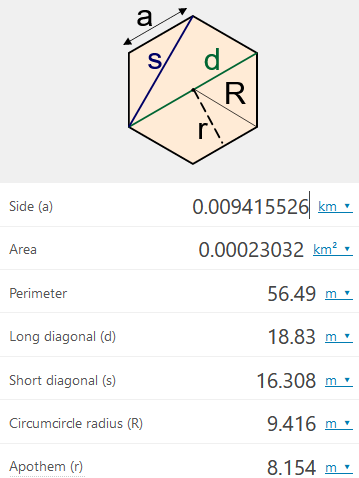

source: https://www.omnicalculator.com/math/hexagon

see https://h3geo.org/docs/core-library/restable/ for hex resolutions and dimensions

In [ ]:
def _get_neighbors(gdf):
    tree = KDTree([gdf.x_epsg31983, gdf.y_epsg31983])
    return DistanceBand(tree, threshold=500, ids=gdf.index.to_numpy())


def _get_transition_locations(lu_maps, t0, t1):
    gdf = _restructure_data(lu_maps, t0, t1)
    return gdf.loc[gdf[t0] != gdf[t1]].index




    


In [ ]:
hexes.hex_12.apply(h3.hex_range, 30)

In [ ]:
transitions = _restructure_data(hexes, 2017, 2020)

In [ ]:
idx = transitions.loc[(transitions['2017']=='retail/services') & (transitions['2020']=='vacant')].index

In [ ]:
f, ax = plt.subplots(figsize=(17, 34))

hexes.loc[(hexes.hex_12.isin(idx)) & (hexes.year=='2020')].plot(color='r', linewidth=0, ax=ax)
cx.add_basemap(ax,
               crs=hexes.crs.to_epsg(),
               source=cx.providers.CartoDB.VoyagerNoLabels,)